# Ноутбук решения команды "Дайте стажировку"
## Команда "Дайте стажировку" *(Максим Тетюхин, Кирилл Ермаков, Никита Котегов, Тимур Рафиков)* готова представить свое решение кейса №1 "Разработка инструментов выдачи ипотеки с помощью моделей машинного обучения"

### Установим и импортируем необходимые модули

In [409]:
''' Потом раскоментировать
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install catboost
'''

' Потом раскоментировать\n!pip install pandas\n!pip install numpy\n!pip install matplotlib\n!pip install seaborn\n!pip install sklearn\n!pip install catboost\n'

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

### Загрузим датасет и посмотрим на него

In [411]:
pathData = '/kaggle/input/spbtechrun24/challenge-mortgage/data/'
df = pd.read_csv(pathData + 'train.csv')

In [412]:
df

,max_floor,state,marital_status,big_market_raion,total_revolving_bal,market_count_1500,leisure_count_3000,total_ct_chng_q4_q1,water_1line,railroad_station_walk_km,...,avg_open_to_buy,build_year,incineration_raion,full_sq,total_relationship_count,detention_facility_raion,build_count_mix,railroad_terminal_raion,__churn,__price_doc
0,NaN,NaN,Single,no,1906,1,0,0.694,no,5.419893,...,1996.9,NaN,no,43,5,no,0.0,no,0,5.850000
1,NaN,NaN,Married,no,12,0,6,0.693,no,3.411993,...,1338.4,NaN,no,34,3,no,0.0,no,0,6.000000
2,NaN,NaN,Married,no,2153,5,0,0.831,no,1.277658,...,2411.5,NaN,no,43,6,no,0.0,no,0,5.700000
3,NaN,NaN,Married,no,1806,2,0,0.638,no,4.291432,...,9255.9,NaN,no,89,3,no,2.0,no,0,13.100000
4,NaN,NaN,Married,no,753,2,40,0.902,no,0.853960,...,3318.2,NaN,no,77,4,no,1.0,yes,0,16.331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20478,16.0,3.0,Married,no,1377,0,0,0.762,yes,2.585823,...,10297.2,1990.0,no,37,6,yes,0.0,no,0,7.200000
20479,17.0,1.0,Married,no,1636,0,0,0.884,no,3.997038,...,2649.9,2013.0,yes,37,6,no,0.0,no,0,4.027052
20480,12.0,3.0,Married,no,1490,2,2,0.654,no,8.649008,...,3258.7,1972.0,no,45,5,no,0.0,no,0,9.650000
20481,17.0,3.0,Single,no,1220,0,0,0.722,no,9.300953,...,10548.1,2007.0,no,64,2,no,0.0,no,1,3.500000


### Разделим признаки на категориальные и численные

In [413]:
targetCols = ['__churn', '__price_doc']
numCols = df.select_dtypes(include=['float64', 'int64']).drop(['__churn', '__price_doc'], axis = 1).columns.to_list()
catCols = df.select_dtypes(include=['object', 'category']).columns.to_list()

print(f'Count of numeric cols: {len(numCols)}')
print(f'Count of categorial cols: {len(catCols)}')
print(f'Target cols: {targetCols}')

Count of numeric cols: 39
Count of categorial cols: 20
Target cols: ['__churn', '__price_doc']


### Посмотрим на распределение целевой переменной

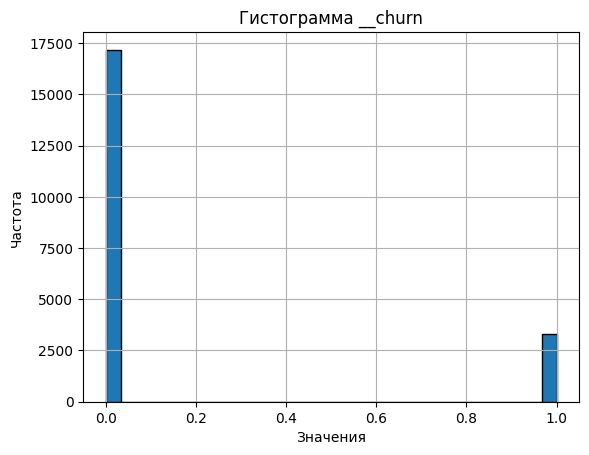

In [414]:
df['__churn'].hist(bins = 30, edgecolor = 'black')
plt.title('Гистограмма __churn')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

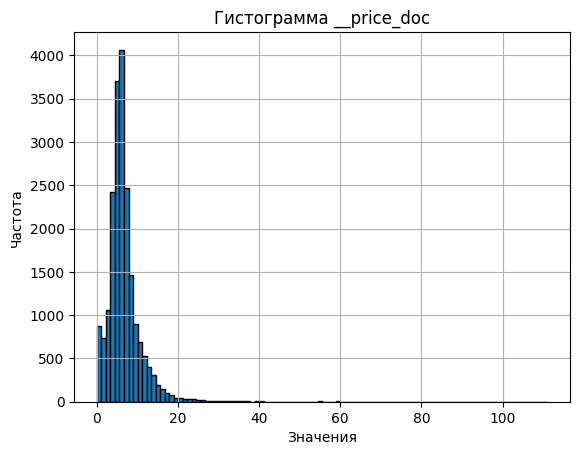

In [415]:
df['__price_doc'].hist(bins = 100, edgecolor = 'black')
plt.title('Гистограмма __price_doc')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

#### Видим, что __churn не сбалансирован (перекос примерно в 5 раз). Поэтому для её предсказания будем использовать метрику ROC-AUC, так как она не чувствительная к не сбалансированным целевым переменным (также причина в том, что метрика на валидационной выборке тоже ROC-AUC).
#### Для предсказания __price_pred будем использовать NMSLE (Negative Mean Squared Logarithmic Error)

### Посмотрим, сколько NaN у количественных признаков

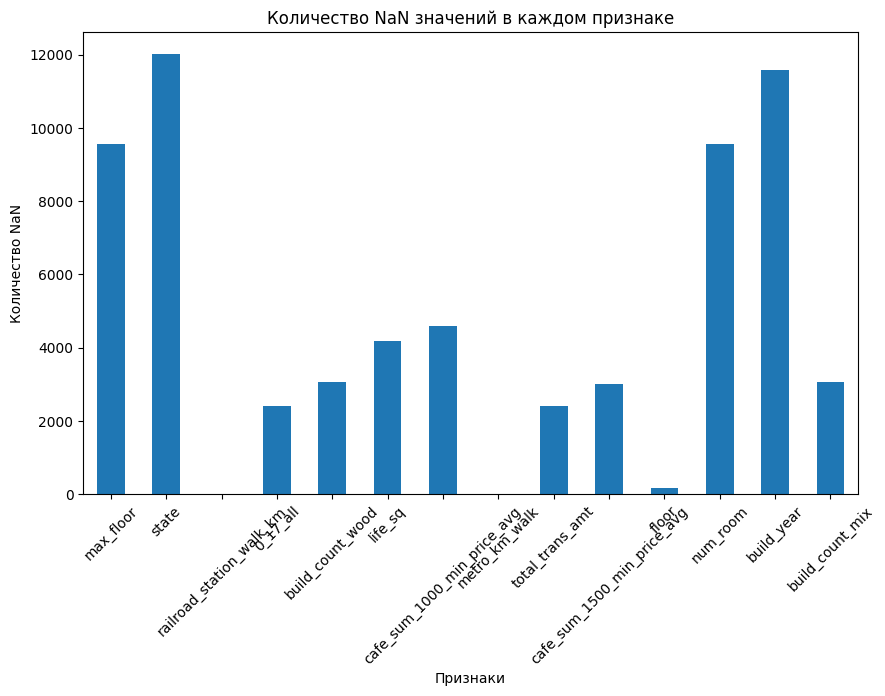

In [416]:
nanCounts = df[numCols].isna().sum()
nanCounts = nanCounts[nanCounts > 0]

plt.figure(figsize = (10, 6))
nanCounts.plot(kind = 'bar')
plt.title('Количество NaN значений в каждом признаке')
plt.xlabel('Признаки')
plt.ylabel('Количество NaN')
plt.xticks(rotation = 45)
plt.show()

#### Заменим их на медиану

In [417]:
df[numCols] = df[numCols].fillna(df[numCols].median())
df[numCols].head()

,max_floor,state,total_revolving_bal,market_count_1500,leisure_count_3000,total_ct_chng_q4_q1,railroad_station_walk_km,contacts_count_12_mon,0_17_all,trc_count_2000,...,cafe_sum_1500_min_price_avg,floor,num_room,months_on_book,dependent_count,avg_open_to_buy,build_year,full_sq,total_relationship_count,build_count_mix
0,12.0,2.0,1906,1,0,0.694,5.419893,2,23603.0,19,...,566.67,4.0,2.0,36,3,1996.9,1978.0,43,5,0.0
1,12.0,2.0,12,0,6,0.693,3.411993,2,17700.0,8,...,694.12,3.0,2.0,29,4,1338.4,1978.0,34,3,0.0
2,12.0,2.0,2153,5,0,0.831,1.277658,2,14884.0,7,...,516.67,2.0,2.0,27,4,2411.5,1978.0,43,6,0.0
3,12.0,2.0,1806,2,0,0.638,4.291432,2,32063.0,7,...,673.91,9.0,2.0,36,2,9255.9,1978.0,89,3,2.0
4,12.0,2.0,753,2,40,0.902,0.853960,2,15237.0,17,...,766.80,4.0,2.0,29,4,3318.2,1978.0,77,4,1.0


In [418]:
df[numCols].isna().sum()

max_floor                                0
state                                    0
total_revolving_bal                      0
market_count_1500                        0
leisure_count_3000                       0
total_ct_chng_q4_q1                      0
railroad_station_walk_km                 0
contacts_count_12_mon                    0
0_17_all                                 0
trc_count_2000                           0
build_count_wood                         0
credit_limit                             0
total_trans_ct                           0
leisure_count_5000                       0
life_sq                                  0
cafe_count_1000_price_1000               0
mkad_km                                  0
school_education_centers_top_20_raion    0
avg_utilization_ratio                    0
public_transport_station_min_walk        0
customer_age                             0
detention_facility_km                    0
sport_count_2000                         0
cafe_sum_10

#### В категориальных признаках нет незаполненных данных, а большинство из них бинарные. У единственный признака timestamp с большим количеством значений оставим только год

In [419]:
df["timestamp"] = df["timestamp"].str.split("-").str[0]

for col in catCols:
    print(f'Значения в "{col}":')
    vc = df[col].value_counts()
    print(vc)
    print()

Значения в "marital_status":
marital_status
Married    11524
Single      8959
Name: count, dtype: int64

Значения в "big_market_raion":
big_market_raion
no     18591
yes     1892
Name: count, dtype: int64

Значения в "water_1line":
water_1line
no     18837
yes     1646
Name: count, dtype: int64

Значения в "culture_objects_top_25":
culture_objects_top_25
no     19367
yes     1116
Name: count, dtype: int64

Значения в "product_type":
product_type
Investment       13440
OwnerOccupier     7043
Name: count, dtype: int64

Значения в "big_road1_1line":
big_road1_1line
no     19940
yes      543
Name: count, dtype: int64

Значения в "card_category":
card_category
Blue      19839
Silver      643
Gold          1
Name: count, dtype: int64

Значения в "income_category":
income_category
Less than $40K    9604
$80K - $120K      4298
$40K - $60K       3141
$60K - $80K       2065
Unknown           1189
$120K +            186
Name: count, dtype: int64

Значения в "thermal_power_plant_raion":
thermal_po

## Анализ данных

### Коррелирующие между собой признаки очень плохо сказываются на обучении модели. Поэтому необходимо убрать их

#### Посчитаем корреляцию численных признаков и удалим одни из самых коррелирующих

In [420]:
corrMatrix = df[numCols].corr()
threshold = 0.7
#print(corrMatrix)

highCorr = []
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > threshold:
            highCorr.append((corrMatrix.columns[i], corrMatrix.columns[j], corrMatrix.iloc[i, j]))

highCorr = pd.DataFrame(highCorr, columns = ['Признак 1', 'Признак 2', 'Корреляция'])
print(highCorr)

                     Признак 1                   Признак 2  Корреляция
0           leisure_count_5000          leisure_count_3000    0.901040
1   cafe_count_1000_price_1000          leisure_count_3000    0.936618
2   cafe_count_1000_price_1000              trc_count_2000    0.723875
3   cafe_count_1000_price_1000          leisure_count_5000    0.851167
4             sport_count_2000              trc_count_2000    0.773725
5             sport_count_2000          leisure_count_5000    0.743738
6             sport_count_2000  cafe_count_1000_price_1000    0.718562
7              office_sqm_5000          leisure_count_3000    0.777536
8              office_sqm_5000          leisure_count_5000    0.921531
9              office_sqm_5000  cafe_count_1000_price_1000    0.759615
10             office_sqm_5000            sport_count_2000    0.770464
11             avg_open_to_buy                credit_limit    0.868753
12             build_count_mix            build_count_wood    0.884076


In [421]:
df.drop(columns = highCorr['Признак 1'].values, inplace = True)
numCols = df.select_dtypes(include=['float64', 'int64']).drop(['__churn', '__price_doc'], axis = 1).columns.to_list()

### Посмотрим, насколько наши численные признаки коррелируют с целевой переменной. Признаки с низкой корреляцией можно выбросить

In [422]:
resNumCols = []
for targ in targetCols:
    corrWithTarget = df[numCols + targetCols].corr()[targ]
    threshold = 0.2
    importantFeatures = corrWithTarget[abs(corrWithTarget) > threshold]
    resNumCols.extend(importantFeatures.index.to_list())

resNumCols = [col for col in resNumCols if col not in targetCols]
print("Result: ", resNumCols, len(resNumCols))

Result:  ['total_revolving_bal', 'total_ct_chng_q4_q1', 'contacts_count_12_mon', 'total_trans_ct', 'total_amt_chng_q4_q1', 'months_inactive_12_mon', 'total_relationship_count', 'detention_facility_km', 'num_room', 'full_sq'] 10


In [423]:
numCols = resNumCols # выбрасываем

In [424]:
numCols

['total_revolving_bal',
 'total_ct_chng_q4_q1',
 'contacts_count_12_mon',
 'total_trans_ct',
 'total_amt_chng_q4_q1',
 'months_inactive_12_mon',
 'total_relationship_count',
 'detention_facility_km',
 'num_room',
 'full_sq']

### Посмотрим, насколько категориальные признаки коррелируют с целевой переменной. Однако, чтобы посчитать корреляцию, нужно привести категориальные признаки в численный вид.
### Так как в целом различных значений у признаков немного (большинство из них бинарные), то можно вместо OHE использовать Label Encoding.

In [425]:
df["timestamp"] = df["timestamp"].str.split("-").str[0]
for col in catCols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

### Посчитаем корреляции и рассмотрим подробнее

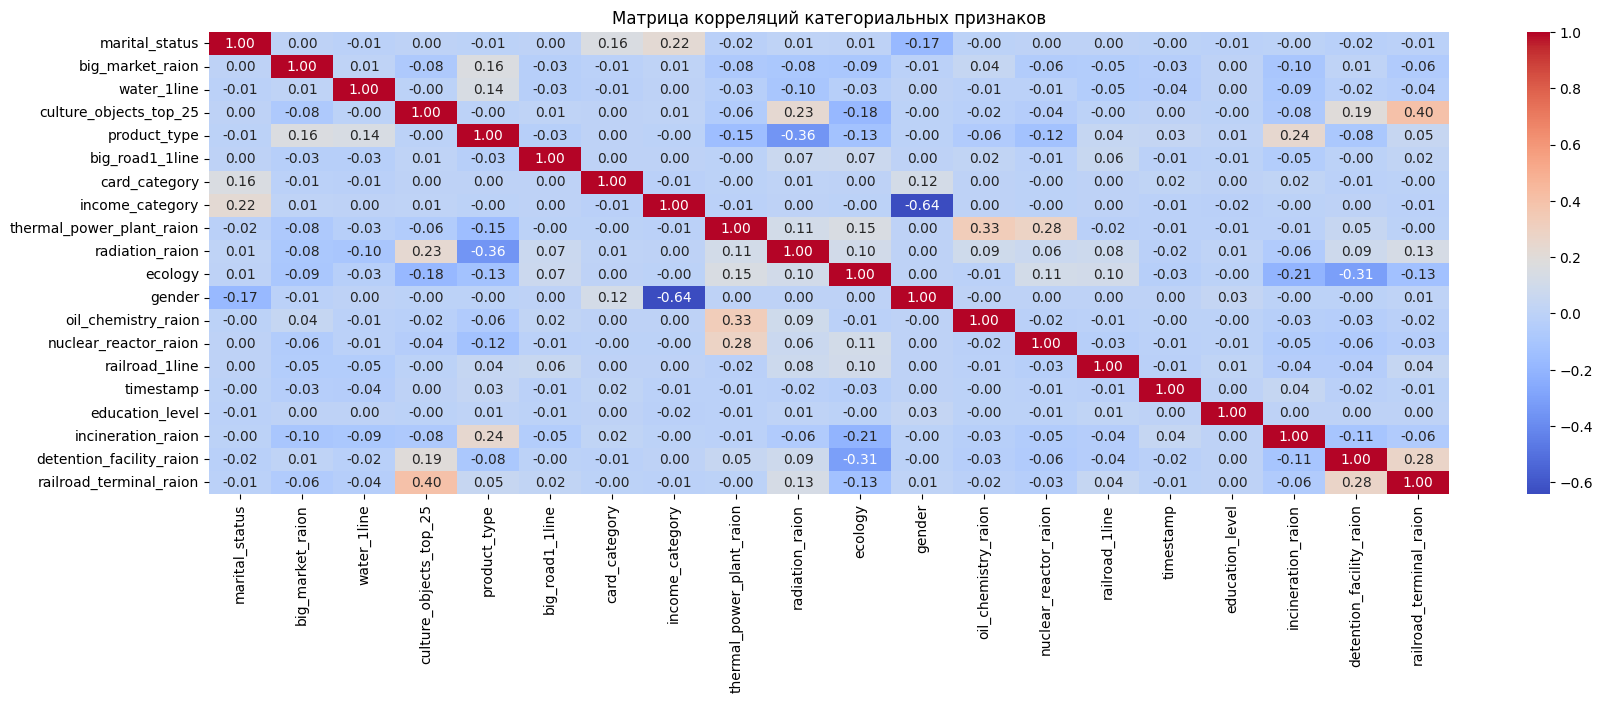

In [426]:
corrMatrix = df[catCols].corr()

plt.figure(figsize=(20, 6))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций категориальных признаков')
plt.show()

In [427]:
threshold = 0.7

highCorr = []
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > threshold:
            highCorr.append((corrMatrix.columns[i], corrMatrix.columns[j], corrMatrix.iloc[i, j]))

highCorr = pd.DataFrame(highCorr, columns = ['Признак 1', 'Признак 2', 'Корреляция'])
print(highCorr)

Empty DataFrame
Columns: [Признак 1, Признак 2, Корреляция]
Index: []


### Категориальные признаки между собой мало коррелируют, рассмотрим их корреляцию с целевыми переменными

In [428]:
resCatCols = []
for targ in targetCols:
    corrWithTarget = df[catCols + targetCols].corr()[targ]
    threshold = 0.1
    importantFeatures = corrWithTarget[abs(corrWithTarget) > threshold]
    resCatCols.extend(importantFeatures.index.to_list())

resCatCols = [col for col in resCatCols if col not in targetCols]
print("Result: ", resCatCols, len(resCatCols))

Result:  ['income_category', 'gender', 'culture_objects_top_25', 'product_type', 'radiation_raion'] 5


In [429]:
catCols = resCatCols # выбрасываем

### Видим, что все остальные категориальные признаки очень мало коррелируют с целевыми переменнами (меньше 0.1), поэтому можем оставить только эти 5. Это очень сильно упростит обучение модели
### Теперь рассмотрим корреляцию наших категориальных и численных признаков вместе

In [430]:
mergCols = numCols + catCols

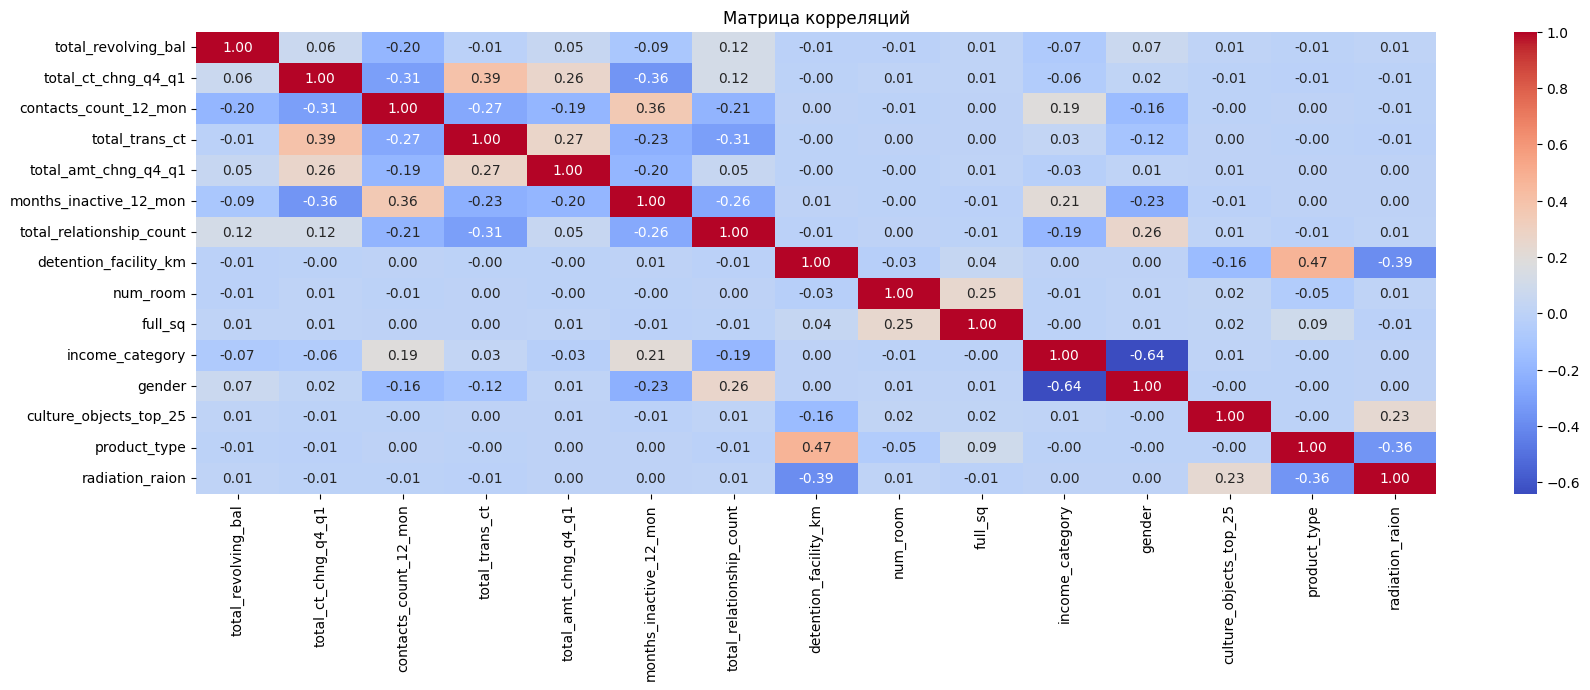

In [431]:
corrMatrix = df[mergCols].corr()

plt.figure(figsize=(20, 6))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

### Видим, что признаки между собой не сильно коррелируют (не превышают 0.7). Однако в этой матрице не отражается сильная корреляция признаков full_sq (площадь) и num_room (количество комнат). Это логично, площадь недвижимости очень сильно зависит от количества комнат. Поэтому убираем full_sq
### Здесь это видно наглядно

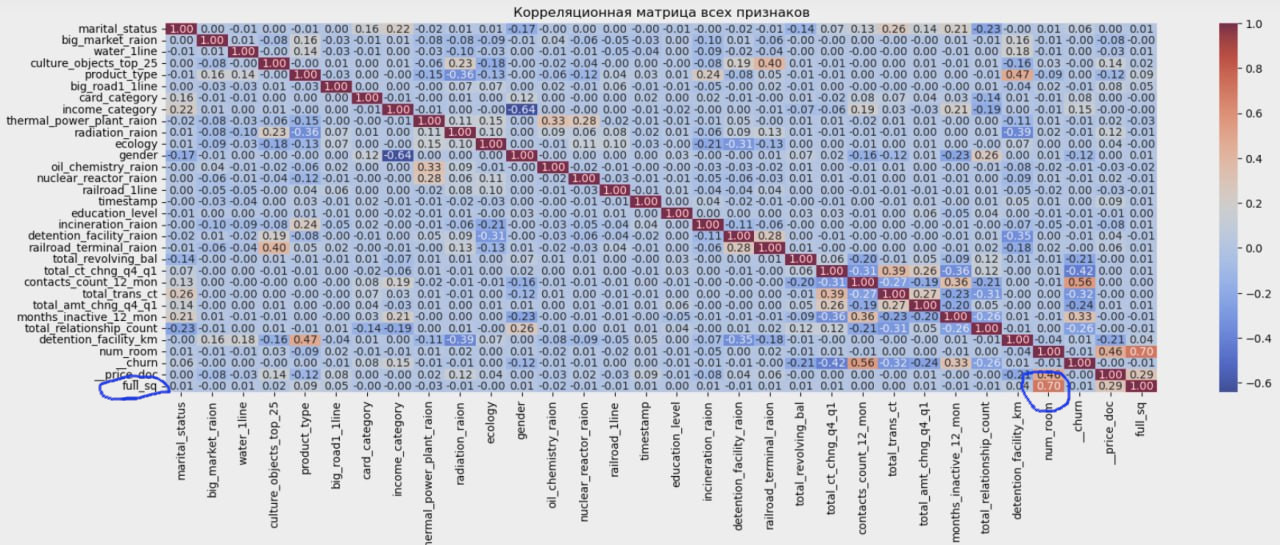

In [432]:
mergCols.remove('full_sq')

In [433]:
resCols = mergCols

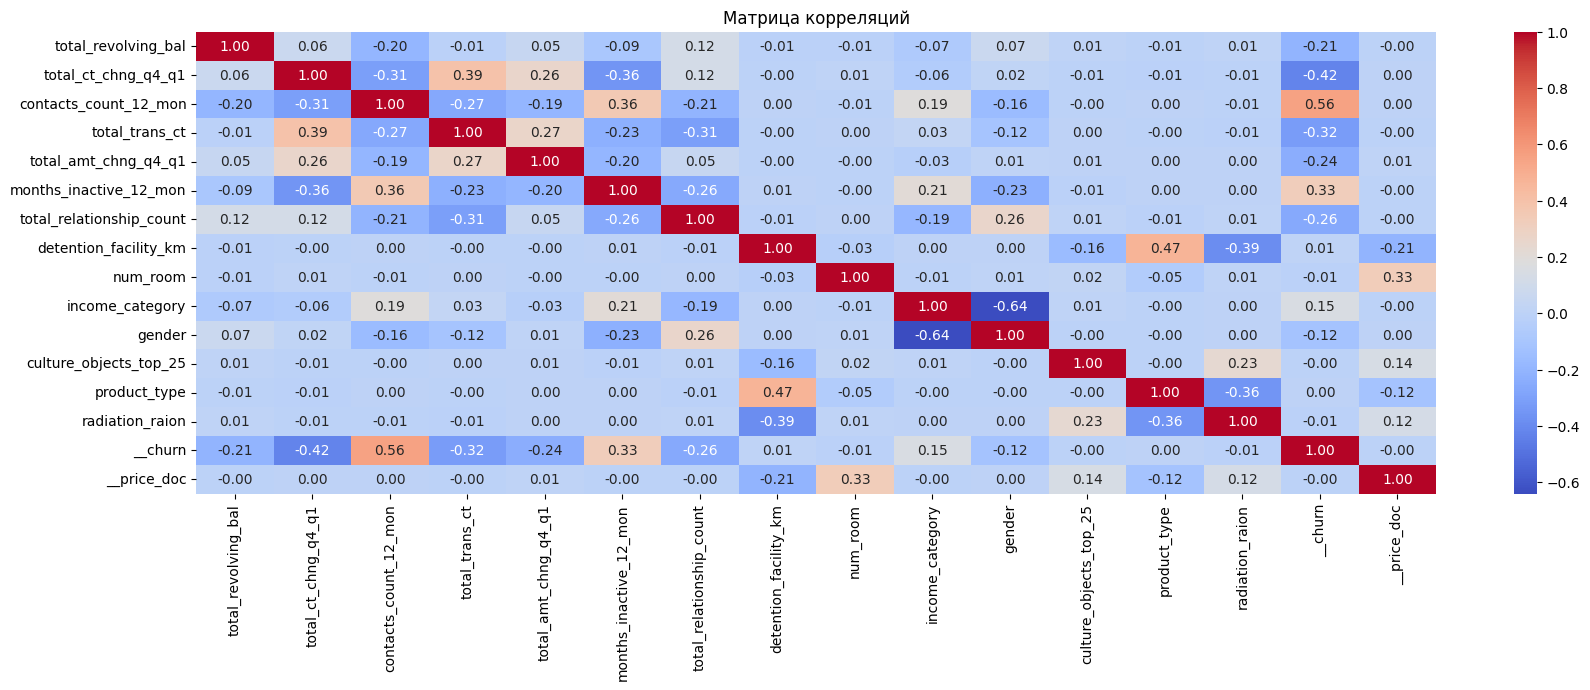

In [434]:
cr = df[resCols + targetCols].corr()

plt.figure(figsize=(20, 6))
sns.heatmap(cr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

 ### Построем для наглядности графики зависимостей наших признаков от целевой переменной

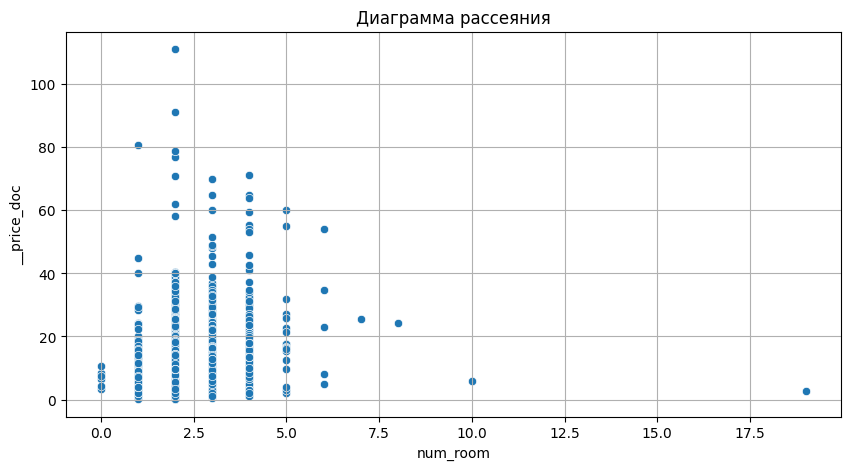

In [435]:
plt.figure(figsize = (10, 5))
sns.scatterplot(x = 'num_room', y = '__price_doc', data = df[resCols + targetCols])
plt.title('Диаграмма рассеяния')
plt.xlabel('num_room')
plt.ylabel('__price_doc')
plt.grid()
plt.show()

# Обучение

In [436]:
resCols = ['income_category',
 'gender',
 'total_revolving_bal',
 'total_ct_chng_q4_q1',
 'contacts_count_12_mon',
 'total_trans_ct',
 'total_amt_chng_q4_q1',
 'months_inactive_12_mon',
 'total_relationship_count',
 'culture_objects_top_25',
 'product_type',
 'radiation_raion',
 'detention_facility_km',
 'num_room']

dfTarget = df[targetCols]
dfres = df[resCols]

resCatCols = ['income_category', 'gender', 'culture_objects_top_25', 'product_type', 'radiation_raion']

## Реализуем обучение Random Forest Regressor для предсказания Churn

In [437]:
dfres

,income_category,gender,total_revolving_bal,total_ct_chng_q4_q1,contacts_count_12_mon,total_trans_ct,total_amt_chng_q4_q1,months_inactive_12_mon,total_relationship_count,culture_objects_top_25,product_type,radiation_raion,detention_facility_km,num_room
0,4,0,1906,0.694,2,66,0.607,3,5,0,0,0,4.248036,2.0
1,1,1,12,0.693,2,75,0.655,2,3,1,0,0,12.649879,2.0
2,1,0,2153,0.831,2,74,0.851,2,6,0,0,1,7.682303,2.0
3,2,1,1806,0.638,2,118,0.709,1,3,0,0,0,8.789894,2.0
4,4,0,753,0.902,2,70,0.791,2,4,0,0,1,3.779781,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20478,3,1,1377,0.762,2,37,0.572,2,6,0,0,0,2.659454,1.0
20479,1,1,1636,0.884,2,42,0.682,3,6,0,0,0,12.213167,1.0
20480,2,1,1490,0.654,2,38,0.810,3,5,0,0,1,16.736130,2.0
20481,5,0,1220,0.722,2,47,0.790,3,2,0,0,0,31.892168,2.0


In [438]:
model1 = RandomForestRegressor(random_state=42,max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=200)

for i in resCatCols:
    encoder = LabelEncoder()
    dfres[i] = encoder.fit_transform(dfres[i])

X_1 = dfres
y_1 = dfTarget['__churn']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42)

model1.fit(X_train, y_train)

/tmp/ipykernel_30/1977431632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfres[i] = encoder.fit_transform(dfres[i])
/tmp/ipykernel_30/1977431632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfres[i] = encoder.fit_transform(dfres[i])
/tmp/ipykernel_30/1977431632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

### Используем метрику ROC AUC как наиболее подходящую


In [439]:
probs_1 = model1.predict(X_test)

roc_auc = roc_auc_score(y_test, probs_1)
print(f'ROC AUC: {roc_auc:.5f}')

prob_churn = model1.predict(X_1)

ROC AUC: 0.96170


## Catboost для задачи регрессии

In [440]:
X = df.drop(columns = ['__churn', '__price_doc'])
y = df['__price_doc']

In [441]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [442]:
model2 = CatBoostRegressor(
    iterations = 300,
    learning_rate = 0.1,
    depth = 10,
    eval_metric = 'RMSE',
    silent = True
)

In [443]:
model2.fit(X_train, y_train, eval_set = (X_test, y_test))

In [444]:
y_pred = model2.predict(X_test)

nmsle = -mean_squared_log_error(y_test, y_pred)
print(f'Negative Mean Squared Logarithmic Error: {nmsle:.4f}')

Negative Mean Squared Logarithmic Error: -0.1368


## Делаем submission

In [445]:
dftest = pd.read_csv(pathData + 'test.csv')

In [446]:
catColsTest = dftest.select_dtypes(include=['object', 'category']).columns.to_list()

In [447]:
dftest["timestamp"] = dftest["timestamp"].str.split("-").str[0]
for i in catColsTest:
    le = LabelEncoder()
    dftest[i] = le.fit_transform(dftest[i])

In [448]:
dftest

,max_floor,state,marital_status,big_market_raion,total_revolving_bal,market_count_1500,leisure_count_3000,total_ct_chng_q4_q1,water_1line,railroad_station_walk_km,...,months_on_book,dependent_count,avg_open_to_buy,build_year,incineration_raion,full_sq,total_relationship_count,detention_facility_raion,build_count_mix,railroad_terminal_raion
0,22.0,3.0,0,0,616,0,1,0.296,1,4.665296,...,40,2,23671.5,1979.0,0,54,3,0,0.0,0
1,16.0,3.0,0,0,1556,1,3,0.671,0,3.516133,...,36,2,3320.3,1978.0,0,37,4,0,1.0,0
2,9.0,2.0,0,0,1030,0,6,0.679,0,1.405934,...,36,3,9752.1,1972.0,0,44,2,0,0.0,0
3,17.0,3.0,0,0,1508,0,0,0.732,0,4.434895,...,49,1,3113.3,2011.0,1,38,4,0,0.0,0
4,48.0,1.0,1,0,1059,0,1,0.840,1,5.852092,...,36,2,203.3,2011.0,0,125,5,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9.0,3.0,1,0,725,2,0,0.977,0,3.147161,...,32,3,1165.3,1975.0,1,44,5,0,0.0,0
9984,9.0,3.0,0,0,1236,1,48,0.883,0,0.902227,...,36,4,3046.1,1935.0,0,86,4,1,1.0,1
9985,20.0,1.0,0,0,2117,0,0,0.761,0,3.735666,...,32,3,3802.7,NaN,0,45,2,0,NaN,0
9986,15.0,2.0,0,0,1167,0,2,0.663,0,6.895862,...,20,4,1912.6,2003.0,0,64,4,0,0.0,0


In [449]:
Xtest1 = dftest[resCols]
Xtest2 = dftest

In [450]:
Xtest1

,income_category,gender,total_revolving_bal,total_ct_chng_q4_q1,contacts_count_12_mon,total_trans_ct,total_amt_chng_q4_q1,months_inactive_12_mon,total_relationship_count,culture_objects_top_25,product_type,radiation_raion,detention_facility_km,num_room
0,3,1,616,0.296,3,40,0.463,3,3,1,0,1,11.218183,2.0
1,1,1,1556,0.671,2,23,0.747,2,4,0,0,1,9.969043,1.0
2,4,0,1030,0.679,1,78,0.782,3,2,0,0,0,12.759534,2.0
3,3,1,1508,0.732,2,74,0.783,1,4,0,0,0,16.606003,1.0
4,4,0,1059,0.840,2,75,0.786,2,5,0,0,1,5.060999,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,4,0,725,0.977,2,74,0.789,2,5,0,0,1,4.589571,2.0
9984,4,0,1236,0.883,2,78,0.891,2,4,1,0,1,0.416625,4.0
9985,1,1,2117,0.761,1,61,0.770,2,2,0,1,0,25.084813,1.0
9986,4,0,1167,0.663,3,35,0.628,2,4,0,0,1,24.788893,2.0


In [451]:
churnPred = model1.predict(Xtest1)
pricePred = model2.predict(Xtest2)

## Алгоритм приоритезации

In [452]:
def alg(x):
    x['pred_priority'] = [a*b for a,b in zip(x['__price_predict'],[1 - i for i in x['__churn_prob']])]
    x = x.sort_values(by='pred_priority',ascending=True)
    x['__priority']  = [i for i in range(0,len(x['pred_priority']))]
    x.drop(columns=['pred_priority'], inplace=True)
    return x

In [453]:
import os

from typing import Any, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_squared_log_error, 
    roc_auc_score
)


def calc_all_metrics(data: Any) -> Dict[str, float]:
    def is_credit_issued(x: Any):
        ratio = x['__price_predict'] / x['__price_doc']
        if x['__priority'] <= 0:
            value = 0.0
        elif 0.9 < ratio < 1.0:
            value = x['__price_predict']
        elif 1.0 <= ratio < 1.1:
            value = x['__price_doc']
        else:
            value = 0.0

        return value

    def calc_profit(x: pd.DataFrame) -> np.array:
        if x['is_credit'] == 0.0:
            return 0.0
        if x['__churn'] == 1:
            return -x['debt'] * 2.0
        if x['debt'] < 5:
            return x['debt'] * 0.3
        if x['debt'] < 9:
            return x['debt'] * 0.4
        if x['debt'] >= 9:
            return x['debt'] * 0.5

    max_account = 25e3
    
    s = (
        data[['__priority', '__churn', '__churn_prob', '__price_doc', '__price_predict']]
        .sort_values('__priority', ascending=False)
        .copy(True)
    )

    s['debt'] = s.apply(is_credit_issued, axis=1)
    s['debt_cum'] = s['debt'].cumsum()
    s['is_credit'] = 0
    s.loc[(s['debt'] > 0) & (s['debt_cum'] <= max_account), 'is_credit'] = 1
    s['profit'] = s.apply(calc_profit, axis=1)

    total_profit = round(s['profit'].sum(), 2)
    good_credits_count = int(s['is_credit'].sum())
    good_credits_debt = int(s[s['is_credit'] == 1]['debt'].sum())
    bad_credits_count = s[s['is_credit'] == 1]['__churn'].sum()

    return {
        'total_profit': int(total_profit),
        'issue_amount': good_credits_debt,
        'bad_loans': round(bad_credits_count / (good_credits_count + bad_credits_count) * 100.0, 1),
        'churn_auc': round(roc_auc_score(y_true=s['__churn'], y_score=s['__churn_prob']), 3),
        'price_nmsle': round(
            -mean_squared_log_error(y_true=s['__price_doc'], y_pred=s['__price_predict']),
            3,
        ),
    }


METRICS_DESC = {
    'total_profit': 'Итоговая полученная прибыль (Ключевая метрика), млн руб.',
    'issue_amount': 'Итоговая выданная сумма (25 000 максимум), млн руб.',
    'bad_loans': 'Доля выданных кредитов с задолженностью, %',
    'churn_auc': 'Метрика ROC AUC по модели предсказания задолженности',
    'price_nmsle': 'Метрика Negative Mean Squared Logarithmic Error по модели предсказания стоимости',
}

In [454]:
# metr = []
# for i in range(0, 9):
#     for j in range(dfpar.shape[0]):
#         if dfpar.iloc[j]['__churn_prob'] > i / 10:
#             dfpar.iloc[j, 4] = -1
#     dfpar['__priority'] = dfpar['__priority'].astype(float)
    
#     pd.concat([
#     dfpar['__price_predict'].describe(),
#     dfpar['__price_doc'].describe(),
#     dfpar['__churn_prob'].describe(),
#     dfpar['__churn'].describe(),
#     ], axis=1)

#     score = pd.Series(calc_all_metrics(dfpar), name='data')
#     dfpar = alg(dfpar)

#     score['desc'] = score.index.map(METRICS_DESC)
#     metr.append((i/10, score.iloc[0]))
# metr = sorted(metr, key=lambda x: x[1])

In [455]:
mysub = pd.DataFrame()
mysub['__price_predict'] = pricePred
mysub['__churn_prob'] = churnPred

mysub = alg(mysub)

In [456]:
mysub

,__price_predict,__churn_prob,__priority
6046,3.342289,0.996375,0
5855,3.247314,0.996160,1
4934,3.316020,0.996130,2
9559,4.326617,0.995821,3
557,4.194887,0.995474,4
...,...,...,...
3413,26.825775,0.001250,9983
8139,27.834141,0.009960,9984
6663,28.277027,0.004771,9985
5694,30.328783,0.065168,9986


In [457]:
for j in range(mysub.shape[0]):
        if mysub.iloc[j]['__churn_prob'] > 0.6 / 10:
            mysub.iloc[j, 2] = -1
mysub['__priority'] = mysub['__priority'].astype(float)

In [458]:
mysub

,__price_predict,__churn_prob,__priority
6046,3.342289,0.996375,-1.0
5855,3.247314,0.996160,-1.0
4934,3.316020,0.996130,-1.0
9559,4.326617,0.995821,-1.0
557,4.194887,0.995474,-1.0
...,...,...,...
3413,26.825775,0.001250,9983.0
8139,27.834141,0.009960,9984.0
6663,28.277027,0.004771,9985.0
5694,30.328783,0.065168,-1.0


In [460]:
mysub = mysub.sort_index()

In [461]:
mysub

,__price_predict,__churn_prob,__priority
0,7.582477,0.933702,-1.0
1,4.650875,0.000130,4425.0
2,4.623339,0.000019,4370.0
3,3.330334,0.000000,2188.0
4,12.909062,0.000000,9742.0
...,...,...,...
9983,5.817544,0.000000,6741.0
9984,15.583806,0.000000,9854.0
9985,4.635473,0.000000,4397.0
9986,9.573378,0.035469,9233.0


In [462]:
mysub.to_csv('/kaggle/working/sub8.csv', index = False)